In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import numpy as np

from typing import Union, List, Tuple

/home/philip/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
transform = transforms.Compose(
        [transforms.ToTensor(), ])
trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                            download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                            shuffle=True, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data


In [3]:
class AutoEncoder(nn.Module):
    
    def __init__(self, 
                 channels:List[int], 
                 kernel:int=4, 
                 stride:int=2, 
                 padding:int=1, 
                 conv_activation=None, 
                 out_activation=None
                ):
        
        super(AutoEncoder, self).__init__()
        
        self.kernel = kernel
        self.stride = stride
        self.padding = padding
        self.conv_activation = nn.SiLU if conv_activation is None else conv_activation
        
        self.encoder = self.build_coder(channels, nn.Conv2d)
        self.decoder = self.build_coder(channels[::-1], nn.ConvTranspose2d)
        self.out_activation = out_activation()
        
    def build_coder(self, channels, conv_layer):
        channel_pairs = zip(channels[:-1], channels[1:])
        coder_steps = [(
            conv_layer(i, o, self.kernel, self.stride, self.padding),
            nn.BatchNorm2d(o),
            self.conv_activation())
            for i, o in channel_pairs]
        coder_steps = [step for substep in coder_steps for step in substep][:-1] # flatten and remove last activation
        return nn.Sequential(*coder_steps)
        
    
    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        if self.out_activation:
            out = self.out_activation(out)
        return out, h
    
m = AutoEncoder([3, 10, 20, 40, 80], out_activation=nn.Sigmoid)
x = torch.randn(1,3,256,256)
m

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 10, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): Conv2d(10, 20, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SiLU()
    (6): Conv2d(20, 40, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): SiLU()
    (9): Conv2d(40, 80, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(80, 40, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): ConvTranspose2d(40, 20, kernel_

In [10]:
model = AutoEncoder([3, 6, 8], out_activation=nn.Sigmoid)
device = "cuda:1"
model.to(device)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 1
pbar = tqdm(total=epochs * len(trainloader))
losses = []

for e in range(epochs):
    for i, (inputs, _) in enumerate(trainloader, 0):
        pbar.update(1)
        inputs = inputs.to(device)
        out, encoded = model(inputs)
        
        loss = criterion(out, inputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        pbar.set_description(desc=f"Epoch {e+1}/{epochs} | average loss: {(sum(losses[-100:])/min(100,len(losses))):.2f}")


  0%|          | 0/3125 [00:00<?, ?it/s]

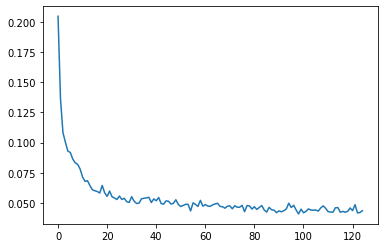

In [11]:
plt.plot(torch.tensor(losses).view(-1, 25).mean(1))

In [6]:
batch = next(iter(trainloader))
image = batch[0][0]
image.shape

torch.Size([3, 32, 32])

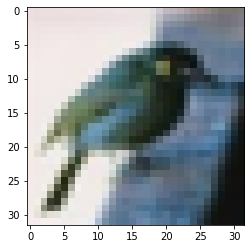

In [8]:
def imshow(img):
  #img = img / 2 + 0.5   # unnormalize
  npimg = img.numpy()   # convert from tensor
  plt.imshow(np.transpose(npimg, (1, 2, 0))) 
  plt.show()
    
imshow(image)

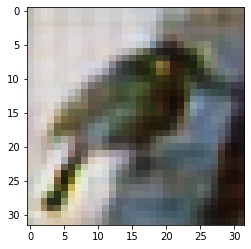

In [9]:
out, h = model(image[None,...])
imshow(out[0].squeeze().detach())

In [12]:
hidden_size = h.shape[1]*h.shape[2]*h.shape[3]
full_size = image.shape[0]*image.shape[1]*image.shape[2]
hidden_size, full_size, 1 - hidden_size / full_size

(512, 3072, 0.8333333333333334)

In [261]:
class VAE(nn.Module):
    
    def __init__(self,
                 input_dims:int,
                 hidden_dims:int,
                 bottleneck_dims:int,
                 convolutions:List[Tuple[int,int,int]]=None, 
                 conv_activation=None, 
                 out_activation=None
                ):
        
        '''
        Variational Auto Encoder
        
        Attributes
        ----------
        
        input_dims : int 
            number of input channel dimensions
        hidden_dims : int
            number of channel dimensions for hidden layers
        bottleneck_dims : int
            channel dimensions at bottelneck
        convolutions : List[Tuple[int,int,int]] (optional)
            list of tuples for convolution layers, of the form (kernel size, stride, padding)
        conv_activation (optional)
            class of the activation to be used for actvations between convolutional layers.  Defaults to SiLU
        out_activation (optional)
            class of the activation to be used after final step of the deocder.  If not set, no activation will be used.
        '''
        
        super(VAE, self).__init__()

        self.input_dims = input_dims
        self.hidden_dims = hidden_dims
        self.bottleneck_dims = bottleneck_dims

        if convolutions is None:
            convolutions = [
                (4, 2, 1),
                (4, 2, 1),
                (5, 1, 0),
                (3, 1, 0)
            ]
            
        if conv_activation is None:
            conv_activation = nn.SiLU
        
        # build encoder
        
        encoder_steps = []
        for i, (k, s, p) in enumerate(convolutions):
            in_dim = input_dims if i == 0 else hidden_dims
            out_dim = (bottleneck_dims * 2) if i == len(convolutions) - 1 else hidden_dims
            encoder_steps.append(nn.Conv2d(in_dim, out_dim, k, s, p))
            encoder_steps.append(nn.BatchNorm2d(out_dim))
            # no activation on last layer
            if i != len(convolutions) - 1:
                encoder_steps.append(conv_activation())
        
        self.encoder = nn.Sequential(*encoder_steps)
        
        # build decoder
        
        decoder_steps = []
        for i, (k, s, p) in enumerate(convolutions[::-1]):
            in_dim = (bottleneck_dims * 2) if i == 0 else hidden_dims
            out_dim = input_dims if i == len(convolutions) - 1 else hidden_dims
            decoder_steps.append(nn.ConvTranspose2d(in_dim, out_dim, k, s, p))
            decoder_steps.append(nn.BatchNorm2d(out_dim))
            # no activation on last layer
            if i != len(convolutions) - 1:
                decoder_steps.append(conv_activation())
        
        self.decoder = nn.Sequential(*decoder_steps)
        
        if out_activation:
            self.out_activation = out_activation()
            
    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=1)
        
        h_dist = torch.distributions.Normal(mu, logvar.mul(.5).exp())
        reference_dist = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(logvar))
        kl_loss = torch.distributions.kl_divergence(h_dist, reference_dist).sum(dim=1).mean()
        
        out = self.decoder(h)
        if self.out_activation:
            out = self.out_activation(out)
        
        return out, kl_loss
            
            
model = VAE(3, 6, 8, out_activation=nn.Tanh)
x = torch.randn(1, 3, 100, 100)
out, kl_loss = model(x)
out.shape, kl_loss

(torch.Size([1, 3, 100, 100]), tensor(6.6694, grad_fn=<MeanBackward0>))

In [2]:
preproc_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                            download=True, transform=preproc_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                            shuffle=True, num_workers=2)

Files already downloaded and verified


In [98]:
model = VAE(3, 128, 256, conv_activation=nn.SiLU, out_activation=nn.ReLU)
model.to(device)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 30
pbar = tqdm(total=epochs * len(trainloader))
losses = []
kl_coeff = 1

for e in range(epochs):
    for i, (inputs, _) in enumerate(trainloader, 0):
        pbar.update(1)
        inputs = inputs.to(device)
        out, kl_loss = model(inputs)
        
        recon_loss = criterion(out, inputs)
        loss = (kl_loss* kl_coeff) + recon_loss
        loss = recon_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        pbar.set_description(desc=f"Epoch {e+1}/{epochs} | average loss: {(sum(losses[-100:])/min(100,len(losses))):.2f}")


  0%|          | 0/11730 [00:00<?, ?it/s]

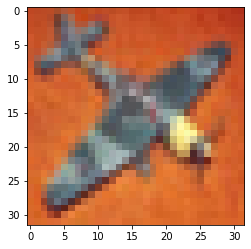

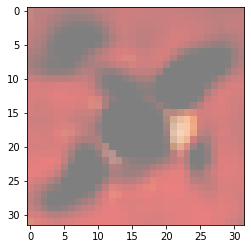

In [96]:
model.train(False)
def imshow(img, un=True):
    if un:
        img = img / 2 + 0.5   # unnormalize
    npimg = img.numpy()   # convert from tensor
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()


image = next(iter(trainloader))[0][0].to(device)
imshow(image.cpu())
out, kl_loss = model(image[None,...])
imshow(out[0].squeeze().cpu().detach())

In [97]:
model.train(False)
encoder_size = model.encoder(image[None,...]).squeeze().shape[0]
full_size = image.shape[0]*image.shape[1]*image.shape[2]
encoder_size, full_size, 1 - encoder_size / full_size, sum([p.numel() for p in model.parameters()])

(1024, 3072, 0.6666666666666667, 8684553)

In [260]:
import torch.nn.functional as F

class EmbeddingQuantizer(nn.Module):

    def __init__(self, codebook_size:int, embedding_dims:int) -> None:
        
        super(EmbeddingQuantizer, self).__init__()

        self.embedding_dims = embedding_dims
        self.codebook_size = codebook_size

        self.embeddings = nn.Embedding(self.codebook_size, self.embedding_dims)

    def forward(self, x):

        B, C, H, W = x.shape

        reshape_inputs = x.permute(0, 2, 3, 1).contiguous() # embed by channel values for each pixel (BHWC)
        reshape_inputs = reshape_inputs.view(-1, self.embedding_dims) # reshape to embedding dimensions (B, E)

        # calculate distances between all inputs and embeddings
        xs = (reshape_inputs**2).sum(dim=1, keepdim=True)
        ys = (self.embeddings.weight**2).sum(dim=1)
        dots = reshape_inputs @ self.embeddings.weight.t()
        distances = (xs + ys) - (2 * dots)

        # get embedding indices and quantize
        embedding_indexes = torch.argmin(distances, dim=1).unsqueeze(1)
        quantized_embeddings = self.embeddings(embedding_indexes).view(B, H, W, C).permute(0, 3, 1, 2).contiguous()

        loss = F.mse_loss(x, quantized_embeddings)

        return quantized_embeddings, embedding_indexes.squeeze(-1), loss

l1 = nn.Linear(32, 32)
eq = EmbeddingQuantizer(1024, 64)
x = torch.randn((1,256,32,32))
x1 = l1(x)
embs, codes, loss = eq(x1)

(tensor(0.7293, grad_fn=<MseLossBackward0>),
 tensor(0.7293, grad_fn=<MseLossBackward0>),
 tensor(0.7293, grad_fn=<MseLossBackward0>))

In [264]:
class VQVAE(VAE):
    
    def __init__(self,
                 input_dims:int,
                 hidden_dims:int,
                 bottleneck_dims:int,
                 codebook_size:int,
                 convolutions:List[Tuple[int,int,int]]=None, 
                 conv_activation=None, 
                 out_activation=None
                ):
        
        '''
        Vector Quantized Variational Auto Encoder
        
        Attributes
        ----------
        
        input_dims : int 
            number of input channel dimensions
        hidden_dims : int
            number of channel dimensions for hidden layers
        bottleneck_dims : int
            channel dimensions at bottelneck (also used as the embedding size for the codebook)
        codebook_size : int
            number of embeddings stored in the codebook
        convolutions : List[Tuple[int,int,int]] (optional)
            list of tuples for convolution layers, of the form (kernel size, stride, padding)
        conv_activation (optional)
            class of the activation to be used for actvations between convolutional layers.  Defaults to SiLU
        out_activation (optional)
            class of the activation to be used after final step of the deocder.  If not set, no activation will be used.
        '''
        
        super(VQVAE, self).__init__(
            input_dims, hidden_dims, bottleneck_dims,
            convolutions, conv_activation, out_activation)

        self.codebook_size = codebook_size
        self.codebook_dims = self.bottleneck_dims * 2 # 1 scalar for mean, 1 for std

        self.embedding_quantizer = EmbeddingQuantizer(self.codebook_size, self.codebook_dims)

    def forward(self, x):

        # run through encoder
        h = self.encoder(x)

        # now get quantized embeddings
        qh, codes, q_loss = self.embedding_quantizer(h)

        # chunk
        mu, logvar = qh.chunk(2, dim=1)
        
        h_dist = torch.distributions.Normal(mu, logvar.mul(.5).exp())
        reference_dist = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(logvar))
        kl_loss = torch.distributions.kl_divergence(h_dist, reference_dist).sum(dim=1).mean()
        
        out = self.decoder(h)
        if self.out_activation:
            out = self.out_activation(out)
        
        return out, codes, q_loss, kl_loss


model = VQVAE(3, 6, 8, 10, out_activation=nn.Tanh)
x = torch.randn(1, 3, 100, 100)
out, codes, q_loss, kl_loss = model(x)
out.shape, codes.shape, q_loss + kl_loss

(torch.Size([1, 3, 100, 100]),
 torch.Size([361]),
 tensor(6.8564, grad_fn=<AddBackward0>))

In [279]:
model = VQVAE(3, 128, 256, 4094, conv_activation=nn.SiLU, out_activation=nn.ReLU)
model.to(device)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 30
pbar = tqdm(total=epochs * len(trainloader))
losses = []

for e in range(epochs):
    for i, (inputs, _) in enumerate(trainloader, 0):
        pbar.update(1)
        inputs = inputs.to(device)
        out, codes, q_loss, kl_loss = model(inputs)
        
        recon_loss = criterion(out, inputs)
        loss = kl_loss + q_loss + recon_loss
        loss = recon_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        pbar.set_description(desc=f"Epoch {e+1}/{epochs} | average loss: {(sum(losses[-100:])/min(100,len(losses))):.2f}")

  0%|          | 0/11730 [00:00<?, ?it/s]

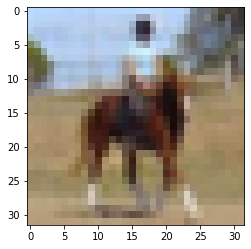

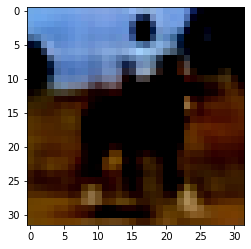

In [280]:
model.train(False)
def imshow(img, un=True):
    if un:
        img = img / 2 + 0.5   # unnormalize
    npimg = img.numpy()   # convert from tensor
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()


image = next(iter(trainloader))[0][0].to(device)
imshow(image.cpu())
out, codes, q_loss, kl_loss = model(image[None,...])
imshow(out[0].squeeze().cpu().detach(), False)

In [301]:
import math

model.train(False)
encoder_size = model.encoder(image[None,...]).squeeze().shape[0]
full_size = image.shape[0]*image.shape[1]*image.shape[2]
bits_per_code = math.ceil(math.log2(model.codebook_size))
codebook_bit_size = codes.shape[0] * bits_per_code
h = "\n".join((
    f"embedding size: {encoder_size}",
    f"original image size: {full_size}",
    f"dimensional reduction: {(1 - encoder_size / full_size)*100:.2f}%",
    f"model params: {sum([p.numel() for p in model.parameters()])}",
    f"codebook bytes: {codebook_bit_size / 8}",
))
print(h)

embedding size: 512
original image size: 3072
dimensional reduction: 83.33%
model params: 4635401
codebook bytes: 6.0


In [81]:
import torch.nn.functional as F
import math

class ResnetBlock(nn.Module):

    def __init__(self, in_channels:int, out_channels:int, stride:int = 1, residual_layer:bool=True, conv_layer=None, conv_activation=None, out_activation=None) -> None:
        super(ResnetBlock, self).__init__()

        assert 0 < stride <= 2

        if conv_activation is None:
            conv_activation = nn.ReLU

        if conv_layer is None:
            conv_layer = nn.Conv2d

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        self.residual_layer = residual_layer

        self.sequence = nn.Sequential(
            conv_layer(in_channels, out_channels, 3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            conv_activation(),
            conv_layer(out_channels, out_channels, 3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        self.out_activation = nn.ReLU() if out_activation is None else out_activation()

    def identity(self, x):
        x = self.make_identity_matrix(x)
        if self.stride == 2:
            x = F.avg_pool2d(x, 2, 2)
        return x
    
    def make_identity_matrix(self, x):

        if self.in_channels == self.out_channels:
            return x

        # we need to add additional channels
        B, C, H, W = x.shape
        NC = self.out_channels - C
        z = torch.zeros(B, NC, H, W, dtype=x.dtype, device=x.device)

        return torch.cat([x, z], dim=1)

    def forward(self, x):

        out = self.sequence(x)
        if self.residual_layer:
            r = self.identity(x)
            print("b", r.shape, out.shape)
            out = self.out_activation(out + r)

        return out

rnb = ResnetBlock(3, 12)
x = torch.randn(1, 3, 32, 32)
rnb(x).shape

b torch.Size([1, 12, 32, 32]) torch.Size([1, 12, 32, 32])


torch.Size([1, 12, 32, 32])